# Lab 9: Classification

## Imports

In [60]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix


## Loading the Dataset

In [61]:
wdbc_data = pd.read_csv('wdbc.data.csv', header=None)

# assign column names
wdbc_data.columns = ['ID', 'Diagnosis', 
                     'Mean Radius', 'Mean Texture', 'Mean Perimeter', 'Mean Area', 'Mean Smoothness', 'Mean Compactness', 'Mean Concavity', 'Mean Concave Points', 'Mean Symmetry', 'Mean Fractal Dimension', 
                     'SE Radius', 'SE Texture', 'SE Perimeter', 'SE Area', 'SE Smoothness', 'SE Compactness', 'SE Concavity', 'SE Concave Points', 'SE Symmetry', 'SE Fractal Dimension', 
                     'Worst Radius', 'Worst Texture', 'Worst Perimeter', 'Worst Area', 'Worst Smoothness', 'Worst Compactness', 'Worst Concavity', 'Worst Concave Points', 'Worst Symmetry', 'Worst Fractal Dimension']

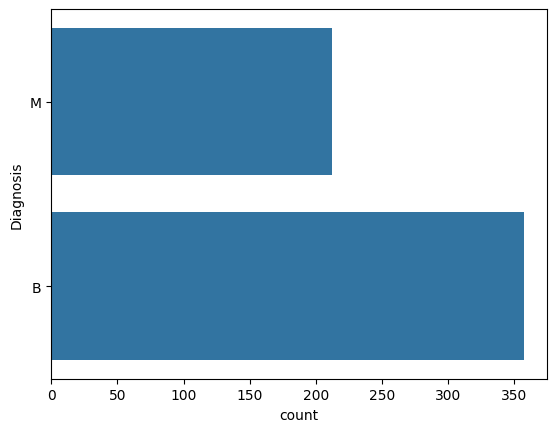

Diagnosis
B    357
M    212
Name: count, dtype: int64
Diagnosis
B    62.741652
M    37.258348
Name: proportion, dtype: float64


In [62]:
# analyze distribution of diagnosis
sns.countplot(wdbc_data['Diagnosis'], label='Count')
plt.show()
print(wdbc_data['Diagnosis'].value_counts())
print(wdbc_data['Diagnosis'].value_counts(normalize=True) * 100)

## Feature Analysis

[Write-up 4] Determine and report the total number of predictive features included in the dataset.

In [63]:
# determine predictive features
# mean, se, worst
features_mean = list(wdbc_data.columns[2:12])
features_se = list(wdbc_data.columns[12:22])
features_worst = list(wdbc_data.columns[22:32])

# drop ID column
wdbc_data.drop('ID', axis=1, inplace=True)

# map diagnosis to binary
wdbc_data['Diagnosis'] = wdbc_data['Diagnosis'].map({'M':1, 'B':0})

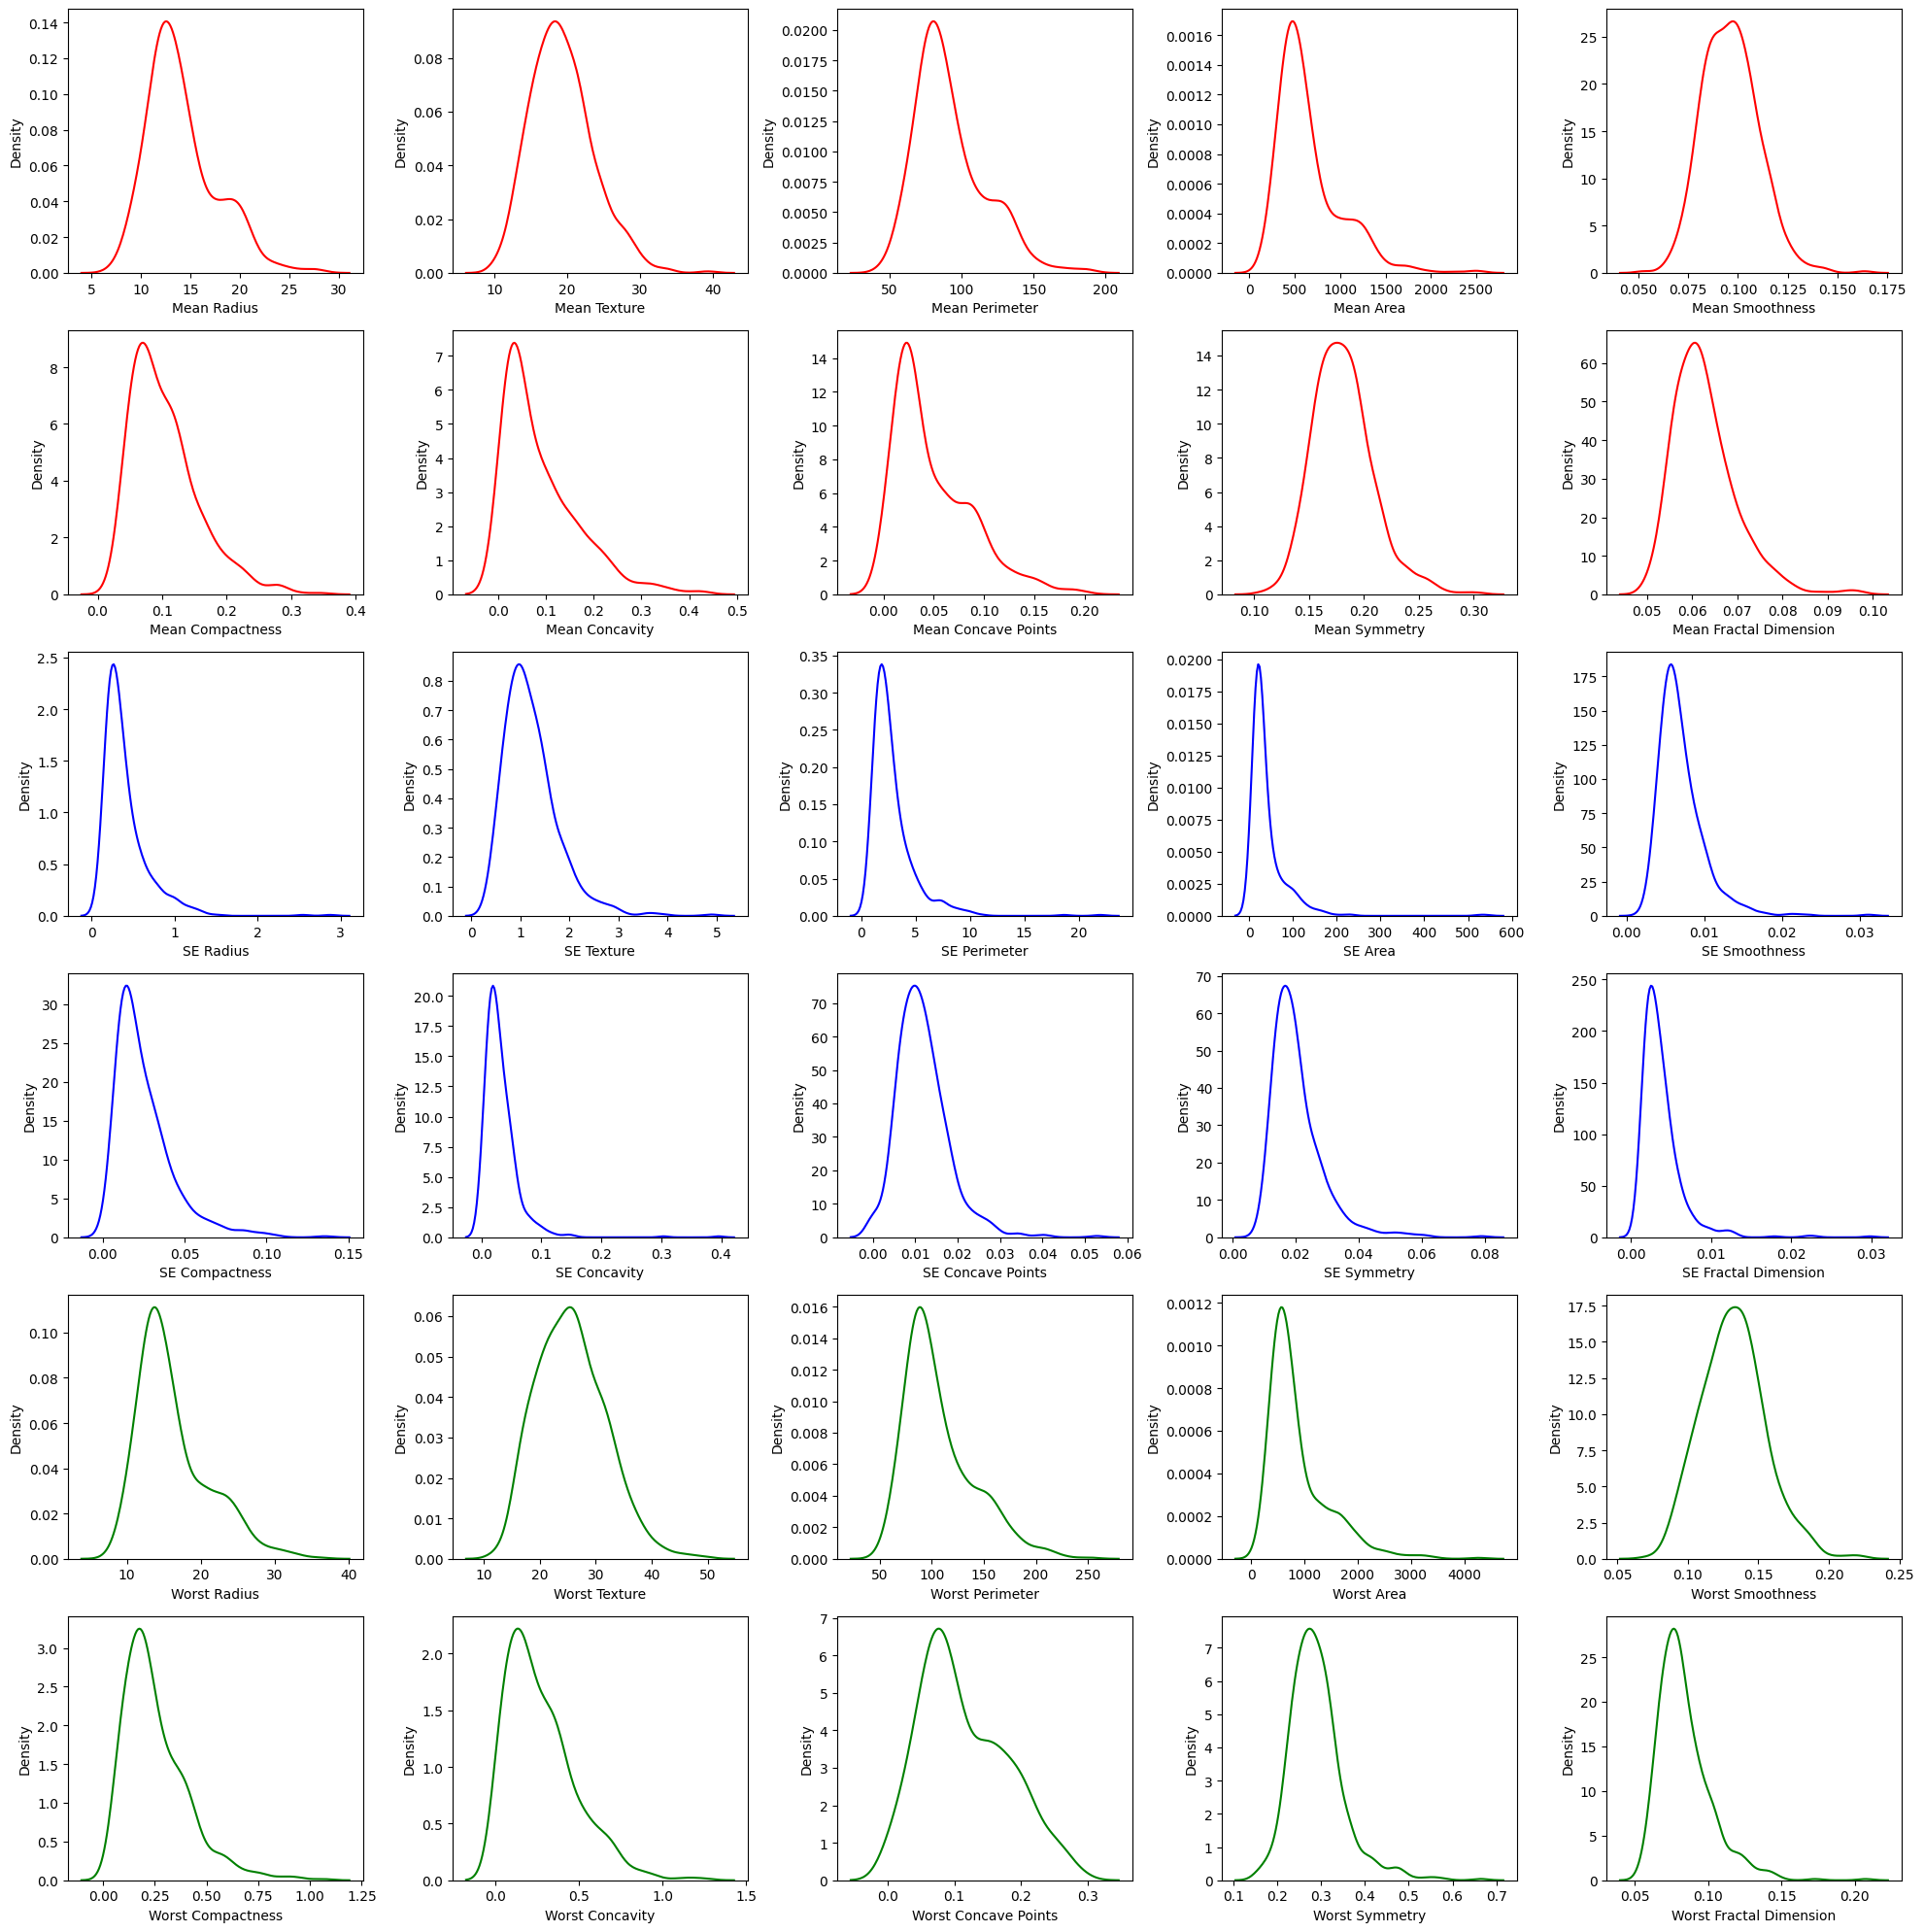

In [64]:
# plot distribution of features
plt.figure(figsize=(20, 20))
for i, feature in enumerate(wdbc_data.columns[1:]):
    plt.subplot(6, 5, i+1)
    color = 'red' if feature in features_mean else 'blue' if feature in features_se else 'green'
    sns.kdeplot(wdbc_data[feature], color=color)
plt.tight_layout()
plt.show()


In [65]:
# test for predictive features 
results = []

for features in features_mean, features_se, features_worst:
    for feature in features:
        malignant = wdbc_data[wdbc_data['Diagnosis'] == 1][feature]
        benign = wdbc_data[wdbc_data['Diagnosis'] == 0][feature]
        ttest = ttest_ind(malignant, benign)
        split = feature.split(' ');
        (featureset, featuretype) = (split[0], "".join(split[1:]))
        results.append([featureset, featuretype, ttest.statistic, ttest.pvalue])

results_df = pd.DataFrame(results, columns=['Type','Feature', 'T-Statistic', 'P-Value'])
results_df['Significant'] = results_df['P-Value'] < 0.05
results_df.sort_values(by=['Feature', 'Type'], inplace=True, ignore_index=True)
print(results_df["Significant"].value_counts())
print(results_df[results_df["Significant"] == False].sort_values(by=['P-Value'], ascending=False))
print(results_df[results_df["Significant"] == True].sort_values(by=['P-Value'], ascending=False))
results_df

Significant
True     25
False     5
Name: count, dtype: int64
    Type           Feature  T-Statistic   P-Value  Significant
25    SE          Symmetry    -0.155298  0.876642        False
28    SE           Texture    -0.197724  0.843332        False
12  Mean  FractalDimension    -0.305711  0.759937        False
22    SE        Smoothness    -1.599365  0.110297        False
13    SE  FractalDimension     1.862330  0.063074        False
     Type           Feature  T-Statistic        P-Value  Significant
10     SE         Concavity     6.246157   8.260176e-10         True
4      SE       Compactness     7.297077   9.975995e-13         True
14  Worst  FractalDimension     8.151316   2.316432e-15         True
24   Mean          Symmetry     8.338312   5.733384e-16         True
21   Mean        Smoothness     9.146099   1.051850e-18         True
7      SE     ConcavePoints    10.642498   3.072309e-24         True
27   Mean           Texture    10.867201   4.058636e-25         True
26  Wors

,Type,Feature,T-Statistic,P-Value,Significant
0,Mean,Area,23.938687,4.734564e-88,True
1,SE,Area,15.609343,5.895521e-46,True
2,Worst,Area,25.721590,2.828848e-97,True
3,Mean,Compactness,17.698392,3.938263e-56,True
4,SE,Compactness,7.297077,9.975995e-13,True
5,Worst,Compactness,17.445374,7.069816e-55,True
6,Mean,ConcavePoints,29.354319,7.101150e-116,True
7,SE,ConcavePoints,10.642498,3.072309e-24,True
8,Worst,ConcavePoints,31.054555,1.969100e-124,True
9,Mean,Concavity,23.103963,9.966556e-84,True


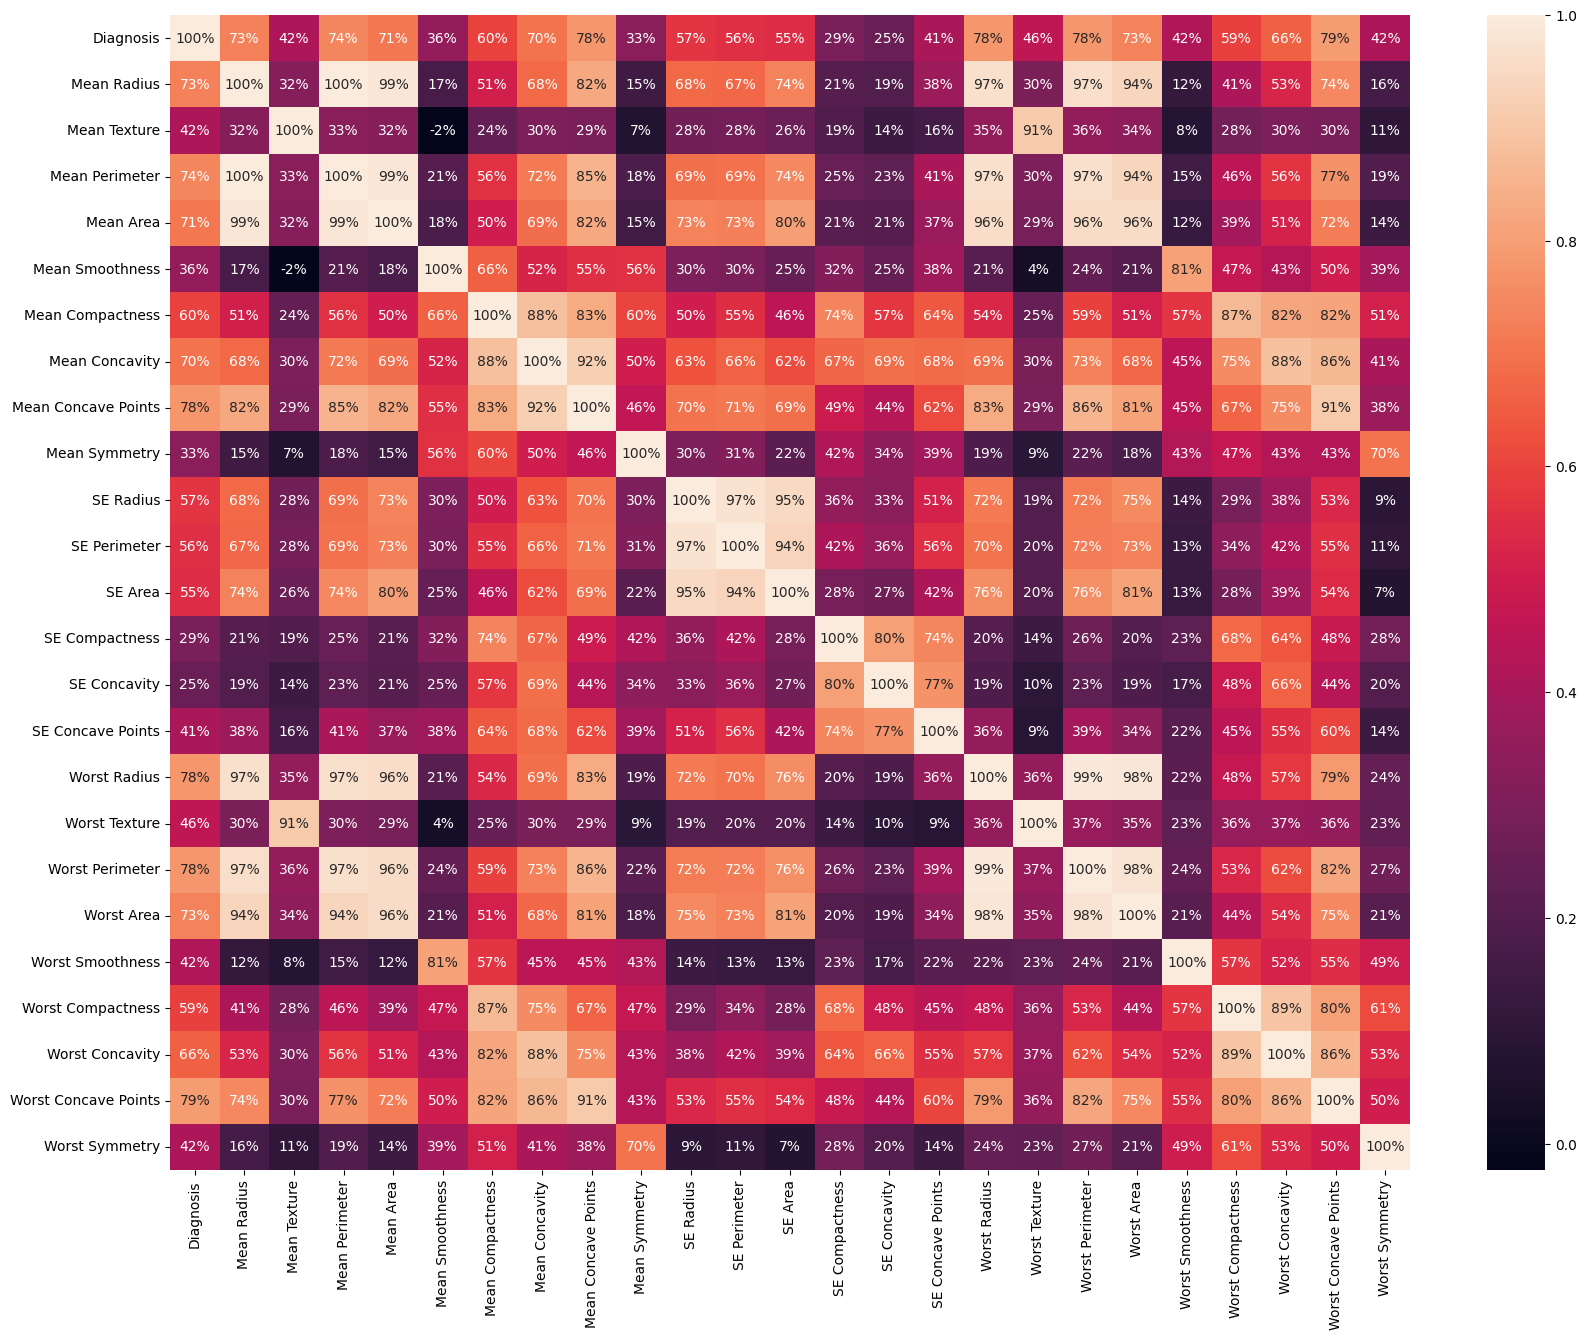

In [66]:

# drop non-significant features
wdbc_data.drop(['Mean Fractal Dimension', 'SE Fractal Dimension', 'Worst Fractal Dimension',
                'SE Texture', 'SE Smoothness', 'SE Symmetry'],
                axis=1, inplace=True)

# plot correlation matrix
plt.figure(figsize=(20, 15))
sns.heatmap(wdbc_data.corr(), annot=True, fmt='.0%')
plt.show()

## Missing Values and Outlier Detection

[Write-up 7] Investigate the dataset for any missing values. Provide a summary of any findings.

[Write-up 8] Select one outlier detection method discussed in this course and apply it to the dataset. Discuss whether any outliers were identified. If you find any potential outliers, explain their possible impact on the classification task.

In [67]:
# investigate for missing values
wdbc_data.isnull().sum()

Diagnosis               0
Mean Radius             0
Mean Texture            0
Mean Perimeter          0
Mean Area               0
Mean Smoothness         0
Mean Compactness        0
Mean Concavity          0
Mean Concave Points     0
Mean Symmetry           0
SE Radius               0
SE Perimeter            0
SE Area                 0
SE Compactness          0
SE Concavity            0
SE Concave Points       0
Worst Radius            0
Worst Texture           0
Worst Perimeter         0
Worst Area              0
Worst Smoothness        0
Worst Compactness       0
Worst Concavity         0
Worst Concave Points    0
Worst Symmetry          0
dtype: int64

In [68]:
# outlier detection
iso = IsolationForest()
# convert diagnosis to binary
outliers = iso.fit_predict(wdbc_data)
wdbc_data["ISO"] = outliers

wdbc_data['ISO'].value_counts()

ISO
 1    504
-1     65
Name: count, dtype: int64

## Data Splitting and Preprocessing

### Implementing 5-Fold Cross Validation
[Write-up 10] Description and Implementation: For this specific dataset, explain how you would apply 5-fold cross-validation to split your data. After describing the process, implement this data splitting strategy in code. Ensure your explanation covers how the dataset is divided into folds, how each fold is used for training and validation across the iterations.

In [69]:
# k-fold cross-validation
strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
X = wdbc_data.drop(['Diagnosis', 'ISO'], axis=1)
folds = []

for train_index, test_index in strat_kf.split(X, wdbc_data['Diagnosis']):
    train = wdbc_data.iloc[train_index]
    test = wdbc_data.iloc[test_index]
    folds.append((train, test))


### Feature Normalization and Model Implementation

Implementation in Code: Based on your decision regarding feature normalization, implement the appropriate pre-processing steps in code. If normalization is performed, ensure it is applied correctly within the context of 5-fold cross-validation.

In [70]:
# feature normalization
scalar = StandardScaler()

for i, (train, test) in enumerate(folds):
    train_X = pd.DataFrame(train.drop(['Diagnosis', 'ISO'], axis=1))
    test_X = pd.DataFrame(test.drop(['Diagnosis', 'ISO'], axis=1))

    train_y = pd.Series(train['Diagnosis'])
    test_y = pd.Series(test['Diagnosis'])

    # normalize
    train_X = scalar.fit_transform(train_X)
    test_X = scalar.transform(test_X)
    train_X = pd.DataFrame(train_X, columns=X.columns)
    test_X = pd.DataFrame(test_X, columns=X.columns)

    folds[i] = (train_X, test_X, train_y, test_y)

## Model Implementation, Evaluation, and Analysis


### Implementing Models with 5-Fold Cross-Validation

Model Implementation: Implement logistic regression and random forest classifiers using the dataset prepared in Part 2. Employ 5-fold cross-validation to train and validate your models, ensuring each fold serves once as the validation set. What are the adjustable settings or parameters in the code for logistic regression and random forest models?

[Write-up 13] Recording Performance Metrics: Record accuracy, sensitivity, specificity, and AUC (area under the curve) for both models for each fold.


In [71]:
# model implementation

def train_model(model, title):
    plt.figure(figsize=(7, 7))
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
    for i, (train_X, test_X, train_y, test_y) in enumerate(folds):
        model.fit(train_X, train_y)
        pred = model.predict_proba(test_X)[:, 1]
        fpr, tpr, _ = roc_curve(test_y, pred)
        model_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, marker='.',
                 label=f'Fold {i+1} (AUC = {model_auc:.2f})')
        print(f'Fold {i+1} AUC: {model_auc:.2f}')
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    return model

# logistic regression relevant params
# tolerance: stopping criterion
# solver options: lbfgs or liblinear
# random_state: for when usin liblinear

def logit_train(solver):
    if solver == "lbfgs":
        logit = LogisticRegression()
    else:
        logit = LogisticRegression(solver=solver, random_state=17)
    title = f'Logistic Regression (Solver = {solver})'
    logit = train_model(logit, title)
    return logit

# random forest relevant params
# n_estimators: number of trees
# max_depth: max depth of tree
# random_state: for reproducibility

def random_forest_train(n_estimators=100, max_depth=None):
    # rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=17)
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=17)
    # title = f'Random Forest (n_estimators = {n_estimators}, max_depth = {max_depth})'
    title = f'Random Forest (n_estimators = {n_estimators})'
    rf = train_model(rf, title)
    return rf

Fold 1 AUC: 1.00
Fold 2 AUC: 1.00
Fold 3 AUC: 0.99
Fold 4 AUC: 1.00
Fold 5 AUC: 1.00


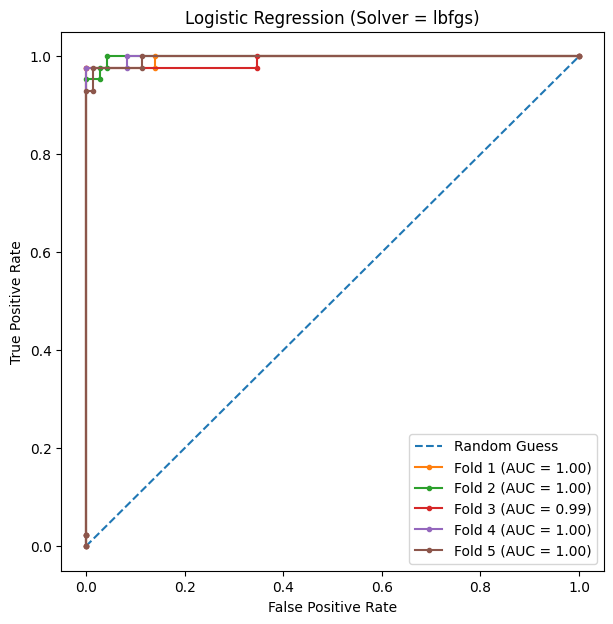

Logistic Regression (lbfgs) Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Fold 1 AUC: 1.00
Fold 2 AUC: 1.00
Fold 3 AUC: 0.99
Fold 4 AUC: 1.00
Fold 5 AUC: 1.00


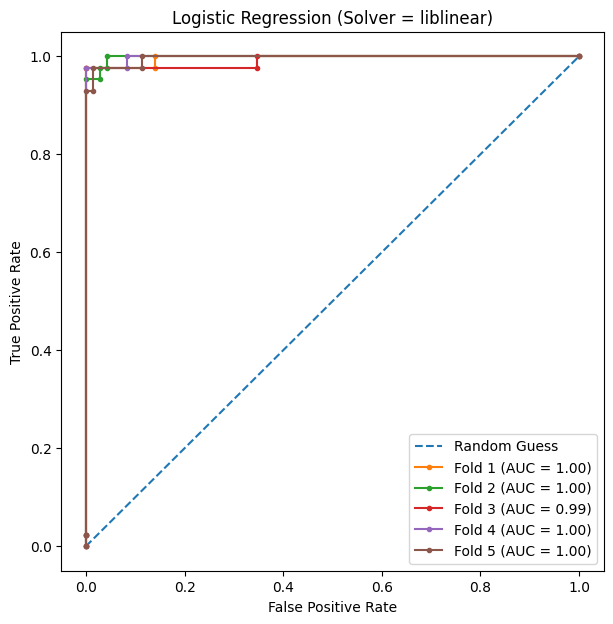

Logistic Regression (liblinear) Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 17, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [72]:
# train and validate models
results = pd.DataFrame()
solvers = ['lbfgs', 'liblinear']

for solver in solvers:
    logit = logit_train(solver)
    scores = [logit.score(fold[1], fold[3]) for fold in folds]
    title = f'Logistic Regression ({solver})'
    df = pd.DataFrame({'Model': title, 'Accuracy': scores, 'Fold': range(1, 6)})
    df.loc[5] = [title, np.mean(scores), 'Mean']
    print(f'{title} Parameters: {logit.get_params()}')
    results = pd.concat([results, df])

Fold 1 AUC: 0.98
Fold 2 AUC: 1.00
Fold 3 AUC: 0.97
Fold 4 AUC: 0.97
Fold 5 AUC: 0.98


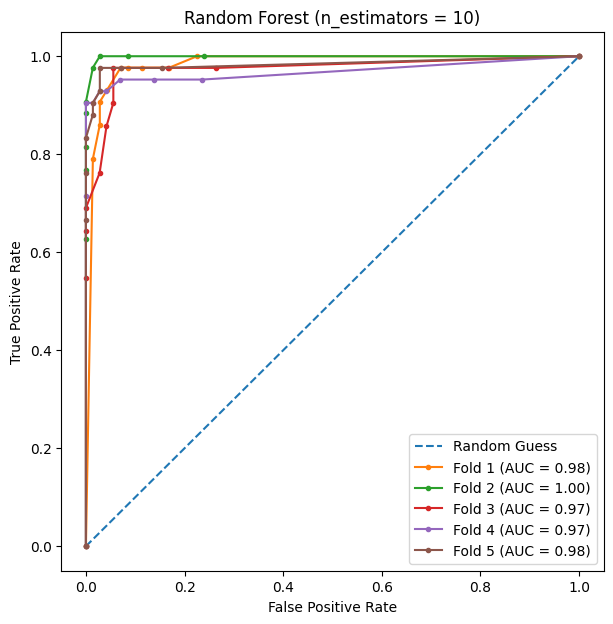

Fold 1 AUC: 0.98
Fold 2 AUC: 1.00
Fold 3 AUC: 0.98
Fold 4 AUC: 0.98
Fold 5 AUC: 0.99


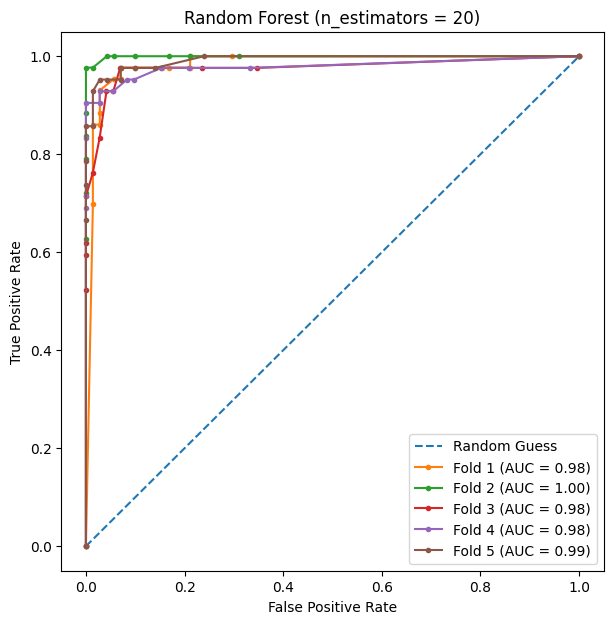

Fold 1 AUC: 0.98
Fold 2 AUC: 1.00
Fold 3 AUC: 0.97
Fold 4 AUC: 0.98
Fold 5 AUC: 0.99


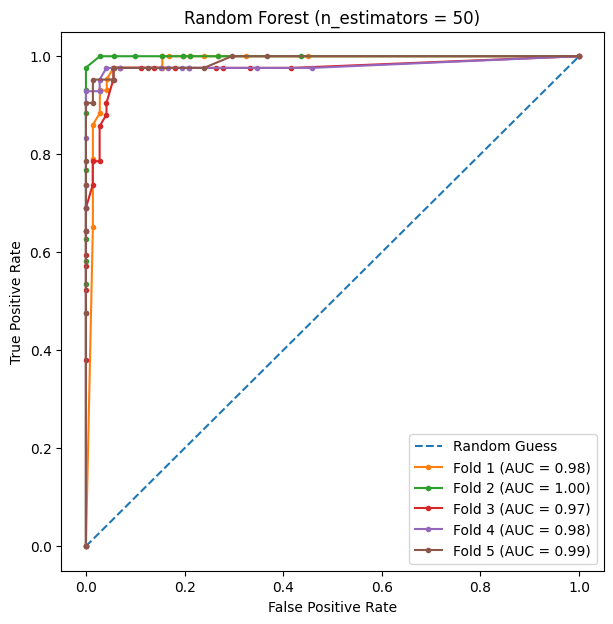

Fold 1 AUC: 0.99
Fold 2 AUC: 1.00
Fold 3 AUC: 0.99
Fold 4 AUC: 0.98
Fold 5 AUC: 0.99


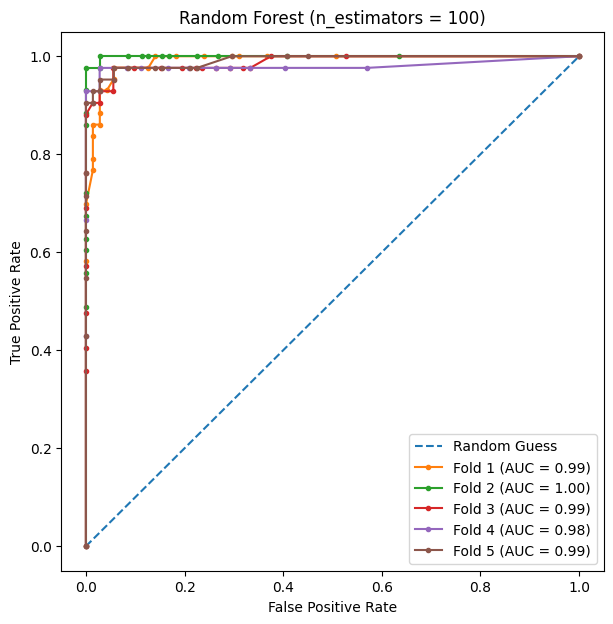

In [73]:
n_estimators = [10, 20, 50, 100]
# max_depths = [None, 10, 15]
# max_depths did not affect the model, like at all
max_depths = [None]

for n in n_estimators:
    for d in max_depths:
        if n == 100 and d == None:
            rf = random_forest_train()
            title = 'Random Forest (default)'
        else:
            rf = random_forest_train(n, d)
            # title = f'Random Forest (n_estimators = {n}, max_depth = {d})'
            title = f'Random Forest (n_estimators = {n})'
        scores = [rf.score(fold[1], fold[3]) for fold in folds]
        df = pd.DataFrame(
            {'Model': title, 'Accuracy': scores, 'Fold': range(1, 6)})
        df.loc[5] = [title, np.mean(scores), 'Mean']
        df.loc[6] = [title, rf.feature_importances_, 'Feature Importance']
        results = pd.concat([results, df])


In [74]:
sorted_results = results[results['Fold'] == 'Mean'].sort_values(by='Accuracy', ascending=False)
# show all columns in jupyter: https://stackoverflow.com/a/64155503
with pd.option_context('display.max_colwidth', None):
  display(sorted_results)

,Model,Accuracy,Fold
5,Random Forest (default),0.989412,Mean
5,Random Forest (n_estimators = 20),0.987657,Mean
5,Random Forest (n_estimators = 50),0.987657,Mean
5,Logistic Regression (lbfgs),0.985934,Mean
5,Logistic Regression (liblinear),0.985934,Mean
5,Random Forest (n_estimators = 10),0.984133,Mean



### Statistical Analysis of Model Performance

Comparative Analysis: Calculate the mean and standard deviation of accuracy, sensitivity, and AUC for both models across all folds.
    
[Write-up 14] Statistical Testing: Choose an appropriate statistical test to compare the two models. Discuss your choice of test and explain why it is suitable for this analysis. Is there a significant difference in performance (focusing on accuracy, sensitivity, and AUC) between the models? Interpret the results.


In [75]:
def report_stats(model, folds, title):
    reports = []
    print(title)
    for i, (X_train, X_test, y_train, y_test) in enumerate(folds):
        model.fit(X_train, y_train)    
        y_pred = model.predict(X_test)
        print(f'  Fold {i+1}')
        report = classification_report(y_test, y_pred, output_dict=True)
        acc = report['accuracy'];
        sens = report['1']['recall'];
        spec = report['0']['recall'];
        auc = roc_auc_score(y_test, y_pred)
        reports.append({
            'Accuracy': acc,
            'Sensitivity': sens,
            'Specificity': spec,
            'AUC': auc,
        })
        print(f'    Accuracy: {acc}')
        print(f'    Sensitivity: {sens}')
        print(f'    Specificity: {spec}')
        print(f'    AUC: {auc}')
    return reports

def summarize_model(model_report):
    model_report = pd.DataFrame.from_dict(model_report)
    summary = []
    print('Summary')
    # get mean and std dev for each column
    for col in model_report.columns:
        mean = model_report[col].mean();
        std_dev = model_report[col].std();
        summary.append({
            'Metric': col,
            'Mean': mean,
            'Std Dev': std_dev,
        })
        print(f'{col}: {mean:.2f} +/- {std_dev:.2f}')
    return summary

In [76]:
# surprise, surprise, the default params perform the best
# final_logit = logit_train('lbfgs')
final_logit = LogisticRegression()
logit_report = report_stats(final_logit, folds, 'Logistic Regression (lbfgs)')
logit_summary = summarize_model(logit_report);

Logistic Regression (lbfgs)
  Fold 1
    Accuracy: 0.956140350877193
    Sensitivity: 0.9767441860465116
    Specificity: 0.9436619718309859
    AUC: 0.9602030789387487
  Fold 2
    Accuracy: 0.9824561403508771
    Sensitivity: 0.9534883720930233
    Specificity: 1.0
    AUC: 0.9767441860465116
  Fold 3
    Accuracy: 0.9912280701754386
    Sensitivity: 0.9761904761904762
    Specificity: 1.0
    AUC: 0.9880952380952381
  Fold 4
    Accuracy: 0.9912280701754386
    Sensitivity: 0.9761904761904762
    Specificity: 1.0
    AUC: 0.9880952380952381
  Fold 5
    Accuracy: 0.9823008849557522
    Sensitivity: 0.9761904761904762
    Specificity: 0.9859154929577465
    AUC: 0.9810529845741114
Summary
Accuracy: 0.98 +/- 0.01
Sensitivity: 0.97 +/- 0.01
Specificity: 0.99 +/- 0.02
AUC: 0.98 +/- 0.01


In [77]:
# final_rf = random_forest_train()
final_rf = RandomForestClassifier()
rf_report = report_stats(final_rf, folds, 'Random Forest (default)')
rf_summary = summarize_model(rf_report);

Random Forest (default)


  Fold 1
    Accuracy: 0.9473684210526315
    Sensitivity: 0.9767441860465116
    Specificity: 0.9295774647887324
    AUC: 0.9531608254176219
  Fold 2
    Accuracy: 0.9649122807017544
    Sensitivity: 0.9069767441860465
    Specificity: 1.0
    AUC: 0.9534883720930232
  Fold 3
    Accuracy: 0.9385964912280702
    Sensitivity: 0.9523809523809523
    Specificity: 0.9305555555555556
    AUC: 0.941468253968254
  Fold 4
    Accuracy: 0.9649122807017544
    Sensitivity: 0.9523809523809523
    Specificity: 0.9722222222222222
    AUC: 0.9623015873015873
  Fold 5
    Accuracy: 0.9557522123893806
    Sensitivity: 0.9047619047619048
    Specificity: 0.9859154929577465
    AUC: 0.9453386988598256
Summary
Accuracy: 0.95 +/- 0.01
Sensitivity: 0.94 +/- 0.03
Specificity: 0.96 +/- 0.03
AUC: 0.95 +/- 0.01


In [81]:
# [Write-up 14] Statistical Testing: 
# Choose an appropriate statistical test to compare the two models. 
# Discuss your choice of test and explain why it is suitable for 
# this analysis. Is there a significant difference in performance 
# (focusing on accuracy, sensitivity, and AUC) between the models? 
# Interpret the results.

# ttest
ttest_results = []
for col in ['Accuracy', 'Sensitivity', 'Specificity', 'AUC']:
    ttest = ttest_rel([report[col] for report in logit_report], [report[col] for report in rf_report])
    ttest_results.append({
        'Metric': col,
        'T-Statistic': ttest.statistic,
        'P-Value': ttest.pvalue,
        'Significant': ttest.pvalue < 0.05,
    })
print('T-Test Results')
print(pd.DataFrame(ttest_results))


T-Test Results
        Metric  T-Statistic   P-Value  Significant
0     Accuracy     3.591960  0.022922         True
1  Sensitivity     2.741677  0.051816        False
2  Specificity     1.729204  0.158830        False
3          AUC     4.191606  0.013789         True


## Feature Importance Analysis
### Analyzing Feature Importance

 [Write-up 15] Discuss strategies to extract the top three most important features from the random forest and logistic regression models. Implement your strategies in code. For both models, do they agree on the top three most important features?

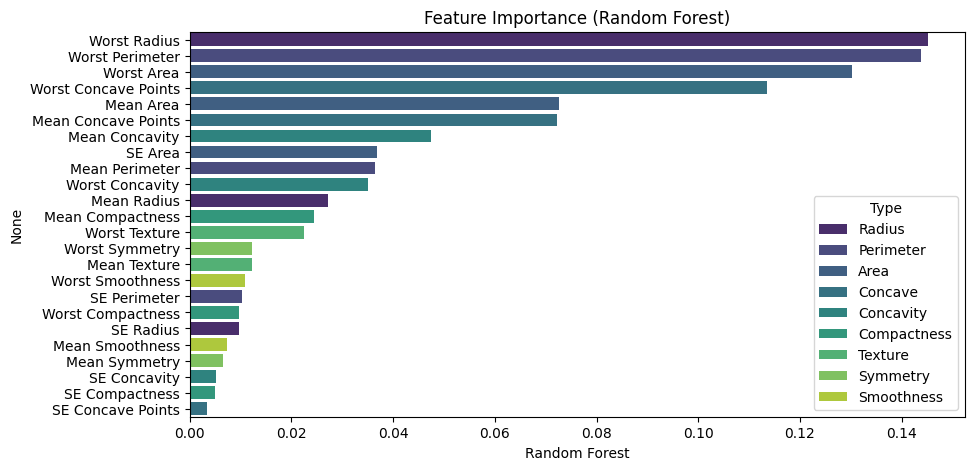

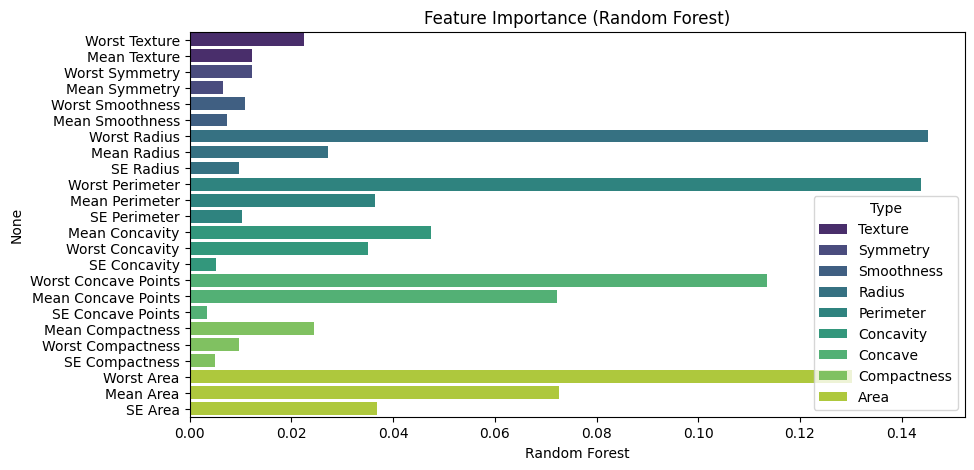

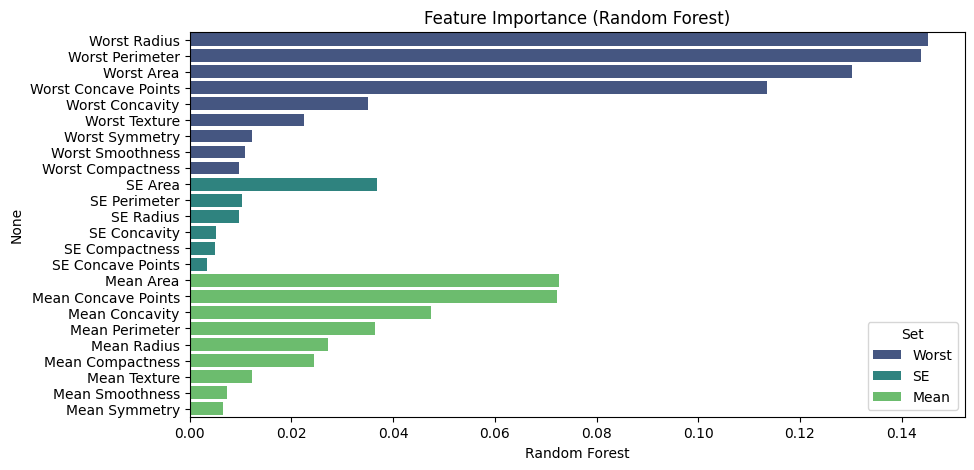

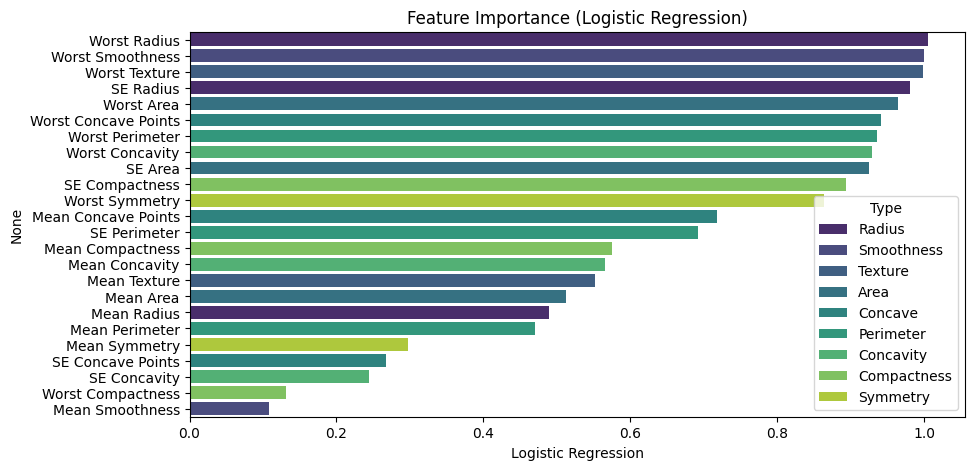

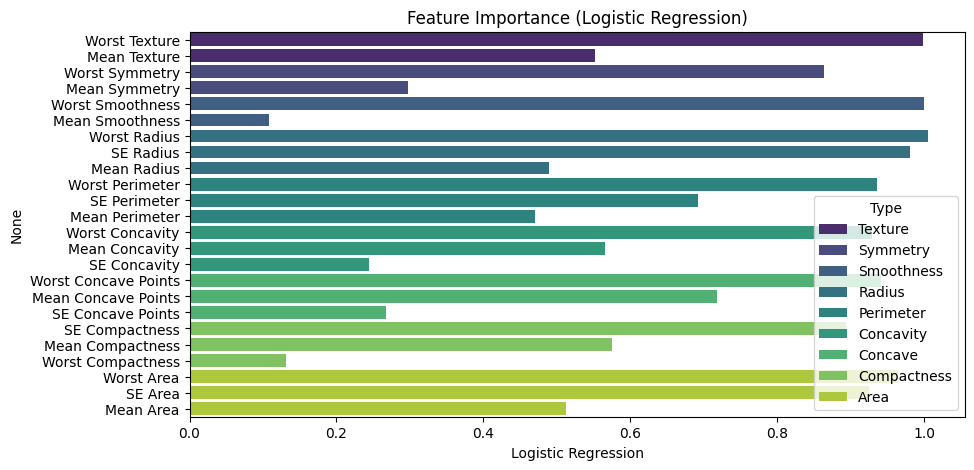

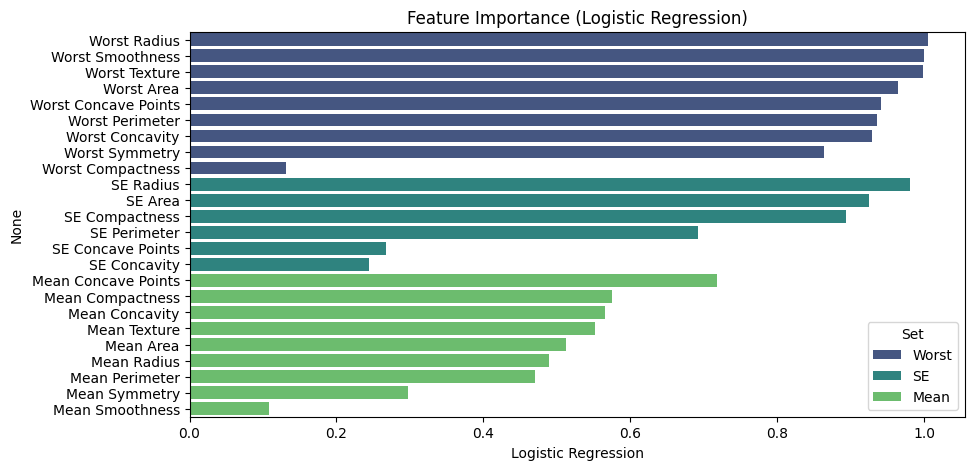

In [79]:
# extracting features
features = pd.DataFrame(index=X.columns)
# since the features are normalized, we can directly use the coefficients
features['Logistic Regression'] = final_logit.coef_[0]
# features['Logistic Regression'] = features['Logistic Regression'].apply(abs)
features['Random Forest'] = final_rf.feature_importances_
features['Set'] = [
    'Mean' if 'Mean' in feature
    else 'SE' if 'SE' in feature
    else 'Worst' for feature in features.index]
features['Type'] = [split[1]
                    for split in features.index.str.split(' ')
                    if len(split) > 1]
# print(features)

# sort features for plotting
for model in ['Random Forest', 'Logistic Regression']:
    for sort_val in [None, 'Type', 'Set']:
        if sort_val is None:
            features.sort_values(by=model, ascending=False, inplace=True, ignore_index=False)
        else:
            features.sort_values(by=[sort_val, model],
                                 ascending=False, inplace=True, ignore_index=False)
        # plot feature importance
        plt.figure(figsize=(10, 5))
        sns.barplot(x=model, y=features.index,
                    data=features, palette='viridis', hue=features[sort_val if sort_val is not None else 'Type'])
        plt.title(f'Feature Importance ({model})')
        plt.show()

In [80]:
# take top 5 features from each model
for i in [3, 5, 6, 10]:
    features.sort_values(by='Random Forest', ascending=False, inplace=True)
    rf_features = features.index[:i]
    features.sort_values(by='Logistic Regression', ascending=False, inplace=True)
    logit_features = features.index[:i]

    # compare features
    print(f'Top {i} Features')
    common_features = set(rf_features).intersection(logit_features)
    print(f'Common Features: {common_features}')
    print(f'Random Forest Features: {rf_features}')
    print(f'Logistic Regression Features: {logit_features}')


Top 3 Features
Common Features: {'Worst Radius'}
Random Forest Features: Index(['Worst Radius', 'Worst Perimeter', 'Worst Area'], dtype='object')
Logistic Regression Features: Index(['Worst Radius', 'Worst Smoothness', 'Worst Texture'], dtype='object')
Top 5 Features
Common Features: {'Worst Radius', 'Worst Area'}
Random Forest Features: Index(['Worst Radius', 'Worst Perimeter', 'Worst Area', 'Worst Concave Points',
       'Mean Area'],
      dtype='object')
Logistic Regression Features: Index(['Worst Radius', 'Worst Smoothness', 'Worst Texture', 'SE Radius',
       'Worst Area'],
      dtype='object')
Top 6 Features
Common Features: {'Worst Concave Points', 'Worst Radius', 'Worst Area'}
Random Forest Features: Index(['Worst Radius', 'Worst Perimeter', 'Worst Area', 'Worst Concave Points',
       'Mean Area', 'Mean Concave Points'],
      dtype='object')
Logistic Regression Features: Index(['Worst Radius', 'Worst Smoothness', 'Worst Texture', 'SE Radius',
       'Worst Area', 'Worst Co